In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from __future__ import division
from functools import partial
import matplotlib.cm as cm
import pickle

from keras.preprocessing import image

import bayesian_changepoint_detection.online_changepoint_detection as oncd
import bayesian_changepoint_detection.offline_changepoint_detection as offcd
from scipy.stats import multivariate_normal,t

import pandas as pd
import sys
sys.path.append('../')

from src import feature_extraction


%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


Use scipy logsumexp().


# Bayesian Switch-Point 

- does online and offline detection. 
- the online is the adam,mckay 2007 method. 

http://nbviewer.jupyter.org/github/hildensia/bayesian_changepoint_detection/blob/master/Example%20Code.ipynb

Based on: 
- [1] Paul Fearnhead, Exact and Efficient Bayesian Inference for Multiple Changepoint problems, Statistics and computing 16.2 (2006), pp. 203--213
- [2] Xuan Xiang, Kevin Murphy, Modeling Changing Dependency Structure in Multivariate Time Series, ICML (2007), pp. 1055--1062
- [3] Ryan P. Adams, David J.C. MacKay, Bayesian Online Changepoint Detection, arXiv 0710.3742 (2007)

## Testing on 1-D Generated Data

In [51]:
def generate_normal_time_series(num, minl=50, maxl=1000):
    data = np.array([], dtype=np.float64)
    partition = np.random.randint(minl, maxl, num)
    for p in partition:
        mean = np.random.randn()*2 # new random mean 
        var = np.random.randn()*1 # new random variance 
        if var < 0:
            var = var * -1
        tdata = np.random.normal(mean, var, p)
        data = np.concatenate((data, tdata))
    return data

In [52]:
np.random.seed(1000)
data = generate_normal_time_series(7, 50, 200)

In [53]:
%time Q, P, Pcp = offcd.offline_changepoint_detection(data, partial(offcd.const_prior, l=(len(data)+1)), offcd.gaussian_obs_log_likelihood, truncate=-40)

CPU times: user 23.6 s, sys: 107 ms, total: 23.7 s
Wall time: 23.7 s


- prior over how likely it is to have two successive change-points. 
    - here they have a uniform prior over length of sequences. So seq len=1,=2,=3 etc. are all equally likely. 
    - I might want to use a poisson. 
- liklihood for data in run sequences (where there is no change-point)
    - here it's a guassian log lik model. 

In [ ]:
Pcp.shape # need to sum to get the probabilities. 

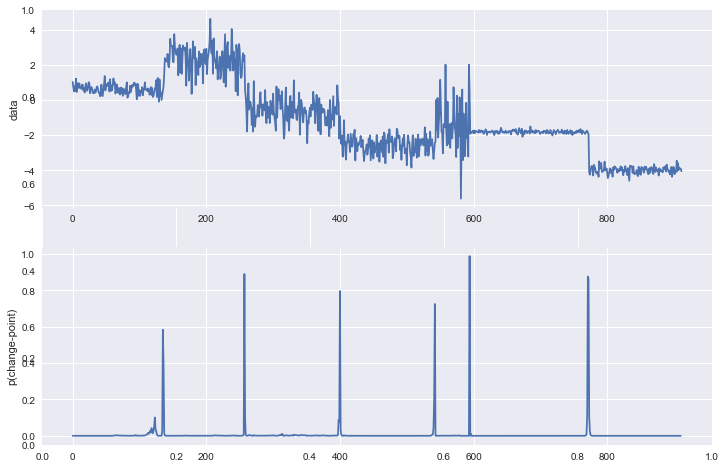

In [55]:
fig, ax = plt.subplots(figsize=[12,8])
ax = fig.add_subplot(2, 1, 1)
ax.plot(data[:])
ax.set_ylabel('data')
ax = fig.add_subplot(2, 1, 2, sharex=ax)
ax.plot(np.exp(Pcp).sum(0))
ax.set_ylabel('p(change-point)')

In [56]:
import bayesian_changepoint_detection.online_changepoint_detection as oncd
reload(oncd)
%time R, maxes = oncd.online_changepoint_detection(data, partial(oncd.constant_hazard, 250), oncd.StudentT(0.1, .01, 1, 0))

CPU times: user 319 ms, sys: 6.42 ms, total: 325 ms
Wall time: 326 ms


- the online c.pd. is much faster because it loops through once and updates the probability of change-points. 


In [57]:
R.shape # are the probabilities over run-lengths

(913, 913)

/Users/chris/anaconda/envs/virtenv/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


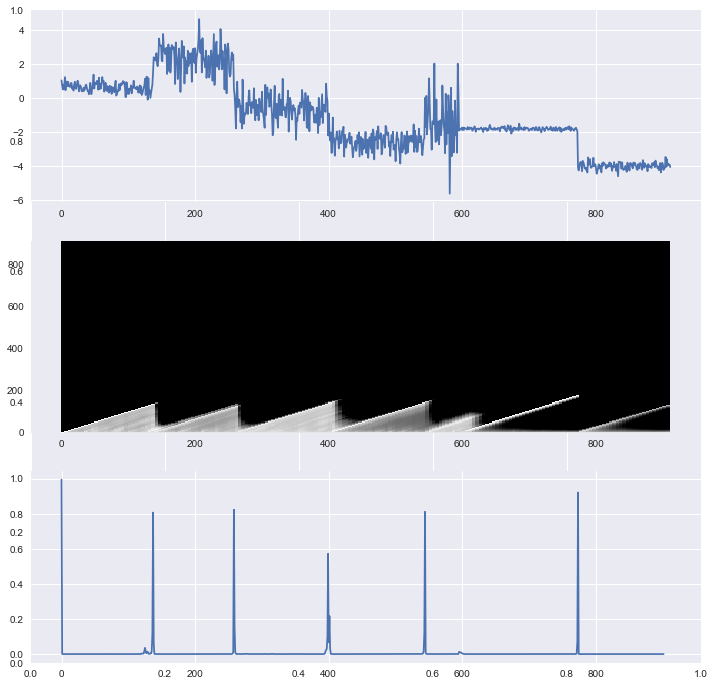

In [58]:
import matplotlib.cm as cm
fig, ax = plt.subplots(figsize=[12,12])
ax = fig.add_subplot(3, 1, 1)
ax.plot(data)
ax = fig.add_subplot(3, 1, 2, sharex=ax)
sparsity = 5  # only plot every fifth data for faster display
ax.pcolor(np.array(range(0, len(R[:,0]), sparsity)), 
          np.array(range(0, len(R[:,0]), sparsity)), 
          -np.log(R[0:-1:sparsity, 0:-1:sparsity]), 
          cmap=cm.Greys, vmin=0, vmax=30)
ax = fig.add_subplot(3, 1, 3, sharex=ax)
Nw=10;
ax.plot(R[Nw,Nw:-1])

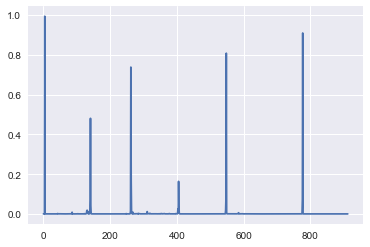

In [66]:
plt.plot(R[4,:])

## Testing on 2-D Generated Data

- generate new dataset

In [3]:
def generate_2D_normal_time_series(number_partitions, minl=50, maxl=1000,dim=2):
    partition = np.random.randint(minl, maxl, number_partitions)
    data = np.zeros((1,dim))
    for p in partition:
        mean = np.random.randn(dim)*2 # new random mean 
        Sigma = np.diag(np.ones(dim)).copy()
        tdata = multivariate_normal.rvs(mean, Sigma, size=p)
        data = np.vstack((data,tdata.copy()))
    data=data[1:,:]
    return data,partition.cumsum()[0:-1]


In [21]:
# generate data
np.random.seed(102) # this works 
data,partition = generate_2D_normal_time_series(3,10,100)


### Offline Method

In [22]:
Q, P, Pcp = offcd.offline_changepoint_detection(data, partial(offcd.const_prior, l=(len(data)+1)), offcd.gaussian_obs_log_likelihood, truncate=-40)

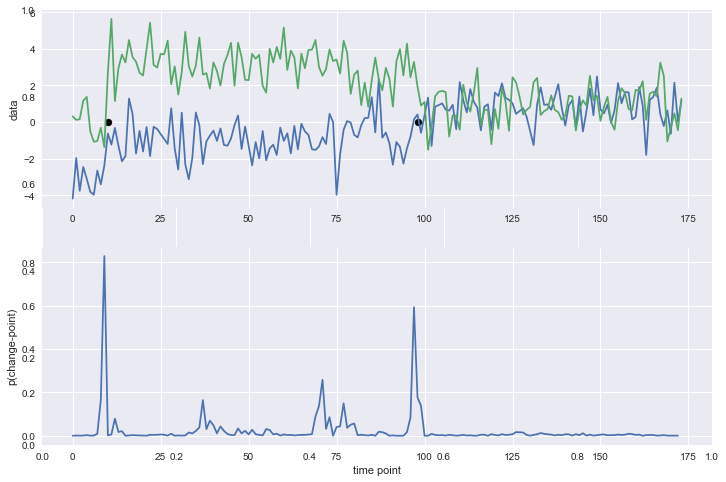

In [31]:
fig, ax = plt.subplots(figsize=[12,8])

ax = fig.add_subplot(2, 1, 1)
ax.plot(data[:])
ax.scatter(partition,np.zeros(len(partition)),c='k') # change points 
ax.set_ylabel('data')
ax = fig.add_subplot(2, 1, 2, sharex=ax)
ax.plot(np.exp(Pcp).sum(0))
ax.set_ylabel('p(change-point)')
ax.set_xlabel('time point')

### Online Method (adapted by chris for multiple dimensions)

In [23]:
# fit model 
R, maxes = oncd.online_changepoint_detection(data, partial(oncd.constant_hazard, 250), oncd.MV_Norm(mu=np.zeros(2),Sigma=np.diag(np.ones(2)),n=np.array([1.0])))
# sometimes need to re-run because of underflow? there are inf's that appear 

In [24]:
R

array([[  1.00000000e+00,   4.00000000e-03,   4.00000000e-03, ...,
          4.00000000e-03,   4.00000000e-03,   4.00000000e-03],
       [  0.00000000e+00,   9.96000000e-01,   3.98400000e-03, ...,
          1.08484064e-03,   1.23774557e-02,   1.07295785e-03],
       [  0.00000000e+00,   0.00000000e+00,   9.92016000e-01, ...,
          8.33851970e-04,   2.46604558e-04,   1.71260033e-03],
       ..., 
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   2.67558967e-84,   1.42027863e-86],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   8.79588576e-85],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

/Users/chris/anaconda/envs/virtenv/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


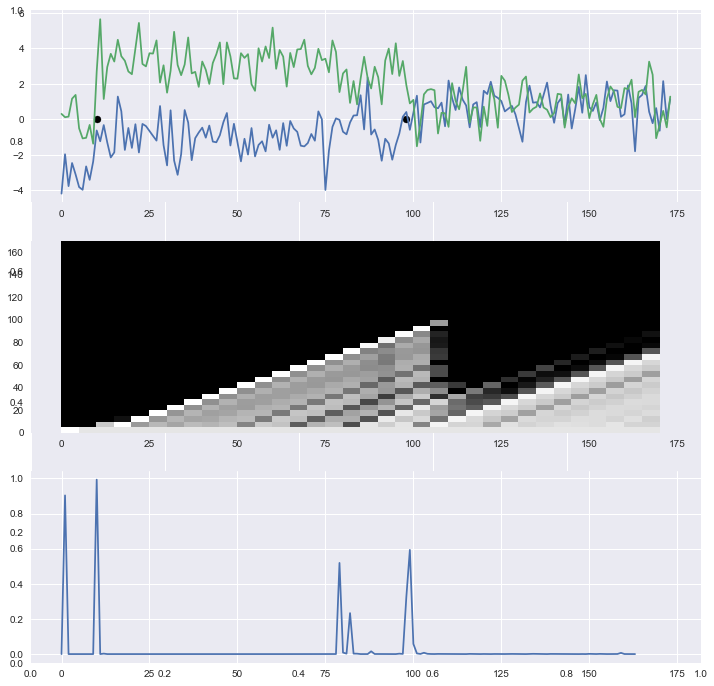

In [25]:
# Plot 
fig, ax = plt.subplots(figsize=[12,12])
ax = fig.add_subplot(3, 1, 1)
ax.plot(data) # time series 
ax.scatter(partition,np.zeros(len(partition)),c='k') # change points 


ax = fig.add_subplot(3, 1, 2, sharex=ax)
sparsity = 5  # only plot every fifth data for faster display
ax.pcolor(np.array(range(0, len(R[:,0]), sparsity)), 
          np.array(range(0, len(R[:,0]), sparsity)), 
          -np.log(R[0:-1:sparsity, 0:-1:sparsity]), 
          cmap=cm.Greys, vmin=0, vmax=30)

ax = fig.add_subplot(3, 1, 3, sharex=ax)
Nw=10;
ax.plot(R[Nw,Nw:-1])

## Testing on black dress - white dress

In [4]:
# get features for 2 folders 
feature_list_black_imgs = feature_extraction.layer_feature_extraction('../data_img_classes/class_black/')
feature_list_white_imgs = feature_extraction.layer_feature_extraction('../data_img_classes/class_white/')

K.image_dim_ordering: tf
K.image_dim_ordering: tf


In [15]:
# concatenate features into a vector (black dresses first, then white dresses)
n_blk_imgs = len(feature_list_black_imgs.keys())
n_white_imgs = len(feature_list_white_imgs.keys())
feature_vec = np.empty((n_blk_imgs+n_white_imgs,2048))
img_files = []
for i,img_file in enumerate(feature_list_black_imgs.keys()+feature_list_white_imgs.keys()):
    if i<n_blk_imgs:
        feature_vec[i,:]=feature_list_black_imgs[img_file]
    else:
        feature_vec[i,:]=feature_list_white_imgs[img_file]
    img_files.append(img_file)
feature_vec.shape

(51, 2048)

In [6]:
n_blk_imgs

23

In [7]:
# reduce dimensionality 
pca_all = pickle.load(open('../data_nn_features/pca_all_items_sample1000.pkl','rb'))

In [55]:
projected_feature_vec = pca_all.transform(feature_vec)
print(projected_feature_vec.shape)



(51, 2048)
(51, 5)


### Plotting the dress sequence

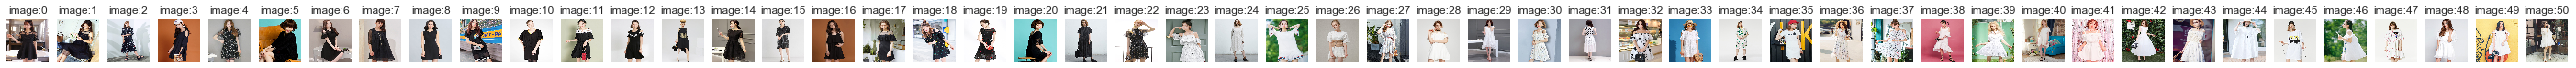

In [31]:
fig,axes =plt.subplots(1,len(img_files),figsize=(50,4))
for i,img_file in enumerate(img_files):
    img = image.load_img(img_file, target_size=(224, 224))
    axes[i].imshow(img)
    axes[i].set_title('image:'+str(i))
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)
plt.savefig('../figures/test.png',dpi=300)

- The dresses switch from black to white at image 22-23

### Offline Method

In [78]:
reduced_projected_feature_vec = projected_feature_vec[:,0:5] 
print(reduced_projected_feature_vec.shape)
input_data=reduced_projected_feature_vec
Q, P, Pcp = offcd.offline_changepoint_detection(input_data, partial(offcd.const_prior, l=(len(input_data)+1)), offcd.gaussian_obs_log_likelihood, truncate=-40)


(51, 5)


(0, 51)

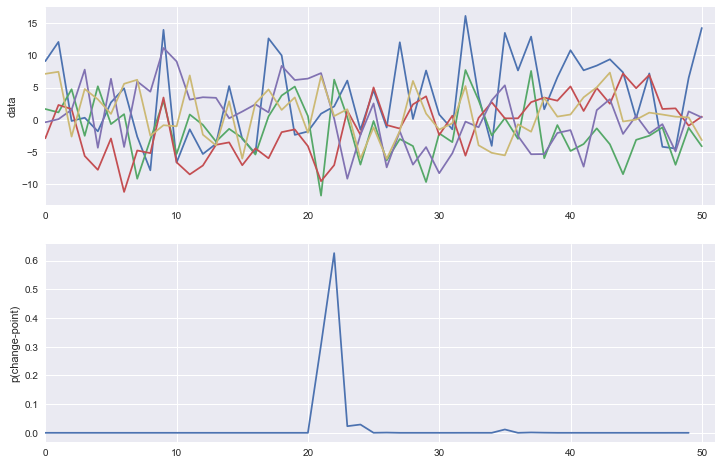

In [79]:
fig, ax = plt.subplots(2,1,figsize=[12,8])

ax[0].plot(input_data[:])
ax[0].set_ylabel('data')
ax[0].set_xlim(0,input_data.shape[0])

ax[1].plot(np.exp(Pcp).sum(0))
ax[1].set_ylabel('p(change-point)')
ax[1].set_xlim(0,input_data.shape[0])

In [82]:
print('change point at image {0}').format(np.argmax(np.exp(Pcp).sum(0)))

change point at image 22


- with 5 PC's, the algorithm picks up the switch from black dresses to white dresses.  

In [73]:
reduced_projected_feature_vec = projected_feature_vec[:,0:50] 
print(reduced_projected_feature_vec.shape)
input_data=reduced_projected_feature_vec
Q, P, Pcp = offcd.offline_changepoint_detection(input_data, partial(offcd.const_prior, l=(len(input_data)+1)), offcd.gaussian_obs_log_likelihood, truncate=-40)


(51, 50)


(0, 51)

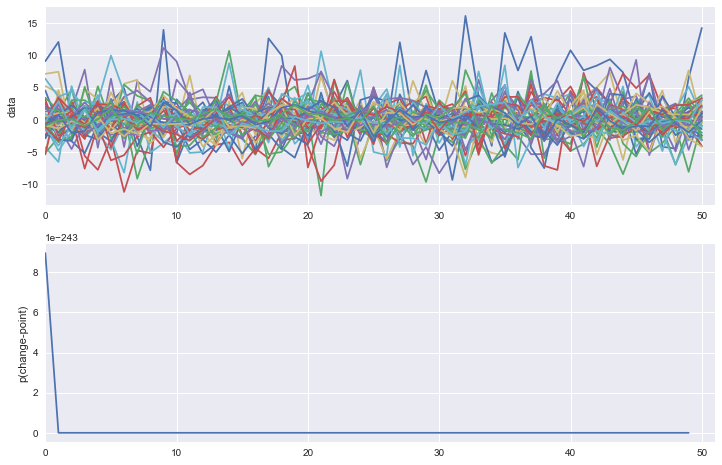

In [74]:
fig, ax = plt.subplots(2,1,figsize=[12,8])

ax[0].plot(input_data[:])
ax[0].set_ylabel('data')
ax[0].set_xlim(0,input_data.shape[0])

ax[1].plot(np.exp(Pcp).sum(0))
ax[1].set_ylabel('p(change-point)')
ax[1].set_xlim(0,input_data.shape[0])

- with too many PC's, the method fails. 

### Online Method (McKay 2007)

In [84]:
reduced_projected_feature_vec = projected_feature_vec[:,0:50] 
print(reduced_projected_feature_vec.shape)
input_data = reduced_projected_feature_vec
R, maxes = oncd.online_changepoint_detection(input_data, partial(oncd.constant_hazard, 250), oncd.MV_Norm(mu=np.zeros(input_data.shape[1]),Sigma=np.diag(np.ones(input_data.shape[1])),n=np.array([1.0])))
# sometimes have to run this twice due to underflow issues

(51, 50)


/Users/chris/anaconda/envs/virtenv/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


(0, 51)

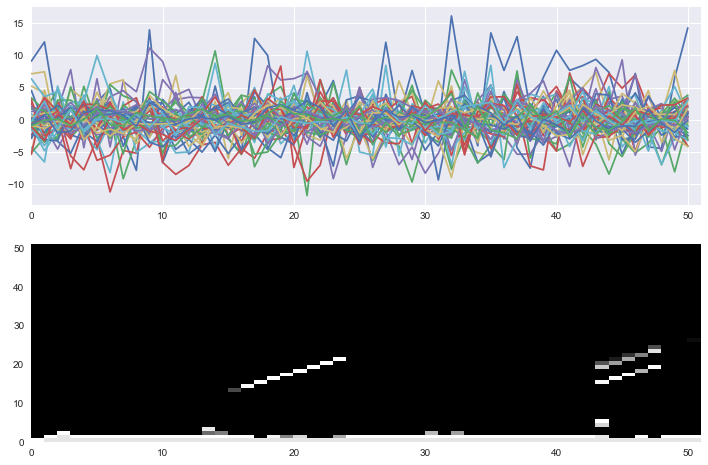

In [85]:
# Plot 
fig, ax = plt.subplots(2,1,figsize=[12,8])

ax[0].plot(input_data) # time series 
ax[0].set_xlim(0,input_data.shape[0])


sparsity = 1  # only plot every fifth data for faster display
ax[1].pcolor(np.array(range(0, len(R[:,0]), sparsity)), 
          np.array(range(0, len(R[:,0]), sparsity)), 
          -np.log(R[0:-1:sparsity, 0:-1:sparsity]), 
          cmap=cm.Greys, vmin=0, vmax=30)
ax[1].set_xlim(0,input_data.shape[0])

# ax = fig.add_subplot(3, 1, 3, sharex=ax)
# Nw=5;
# ax.plot(R[Nw,Nw:-1])

- here the algorithm estimate that at image 23, there is a 23 image run length with high probability. 
- at image 24 the probability of the run length drops back to 1. 
- this algorithm does better with the higher dimensional input 

In [97]:
reduced_projected_feature_vec = projected_feature_vec[:,0:5] 
print(reduced_projected_feature_vec.shape)
input_data = reduced_projected_feature_vec
R, maxes = oncd.online_changepoint_detection(input_data, partial(oncd.constant_hazard, 250), oncd.MV_Norm(mu=np.zeros(input_data.shape[1]),Sigma=np.diag(np.ones(input_data.shape[1])),n=np.array([1.0])))
# sometimes have to run this twice due to underflow issues

(51, 5)


/Users/chris/anaconda/envs/virtenv/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


(0, 51)

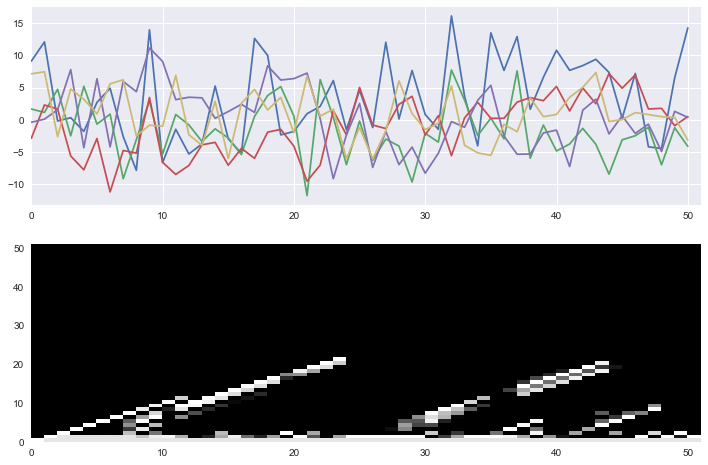

In [98]:
# Plot 
fig, ax = plt.subplots(2,1,figsize=[12,8])

ax[0].plot(input_data) # time series 
ax[0].set_xlim(0,input_data.shape[0])


sparsity = 1  # only plot every fifth data for faster display
ax[1].pcolor(np.array(range(0, len(R[:,0]), sparsity)), 
          np.array(range(0, len(R[:,0]), sparsity)), 
          -np.log(R[0:-1:sparsity, 0:-1:sparsity]), 
          cmap=cm.Greys, vmin=0, vmax=30)
ax[1].set_xlim(0,input_data.shape[0])

# ax = fig.add_subplot(3, 1, 3, sharex=ax)
# Nw=5;
# ax.plot(R[Nw,Nw:-1])

- though it appears to do better in with 5 top PC's (hard to tell). 


## Plot change-points for our example sequences

In [2]:
# load an example trajectory 
folder='../data_img_sample_item_view_sequences/'
from src.data_management import get_meta_data_from_sequence_data
df = get_meta_data_from_sequence_data(folder)
df.head()


,user_id,view_position,spu,view_seconds,tag,jpg
0,1026336619,10,18935327703625752,30,view,.jpg
1,1026336619,11,225819416539443204,8,view,.jpg
2,1026336619,12,452688254114283543,7,view,.jpg
3,1026336619,13,308854529632018448,14,view,.jpg
4,1026336619,14,323209760887509007,13,view,.jpg


In [3]:
# get pca
pca_all = pickle.load(open('../data_nn_features/pca_all_items_sample1000.pkl','rb'))

In [4]:
def sort_feature_list_keys(feature_list):
    return(list(np.array(feature_list.keys())[np.argsort(np.array([int(key.split('_')[-5]) for key in feature_list.keys()]))]))

In [5]:
def change_point_per_user(user_id,pca_all,n_PCs=5):
    
    #print('extracting')
    # extract features per user 
    feature_list= feature_extraction.layer_feature_extraction('../data_img_sample_item_view_sequences/',filter='*'+user_id+'*')

    # sort by view order
    feature_file_list = sort_feature_list_keys(feature_list)

    # convert to matrix
    n_imgs =len(feature_list)
    feature_vec = np.empty((n_imgs,2048))
    img_files = []
    for i,img_file in enumerate(feature_file_list):
        feature_vec[i,:]=feature_list[img_file]
        img_files.append(img_file)

    # pca transform 
    projected_feature_vec = pca_all.transform(feature_vec)

    # reduce dimensionality 
    reduced_projected_feature_vec = projected_feature_vec[:,0:n_PCs] 


    # change-point method 1
    input_data = reduced_projected_feature_vec
    R, maxes = oncd.online_changepoint_detection(input_data, partial(oncd.constant_hazard, 250), oncd.MV_Norm(mu=np.zeros(input_data.shape[1]),Sigma=np.diag(np.ones(input_data.shape[1])),n=np.array([1.0])))

    # change-point method 2
    Q, P, Pcp = offcd.offline_changepoint_detection(input_data, partial(offcd.const_prior, l=(len(input_data)+1)), offcd.gaussian_obs_log_likelihood, truncate=-40)

    return(R,Pcp,img_files)


In [18]:
def plot_image_sequence(img_files,user_id,show=True):
    fig,axes =plt.subplots(1,len(img_files),figsize=(50,4))
    for i,img_file in enumerate(img_files):
        img = image.load_img(img_file, target_size=(224, 224))
        axes[i].imshow(img)
        axes[i].set_title('image:'+str(i))
        axes[i].get_xaxis().set_visible(False)
        axes[i].get_yaxis().set_visible(False)
    plt.savefig('../figures/img_sequences/seq_'+user_id+'.png',dpi=300)
    if show==False:
        plt.close()

In [67]:
def plot_change_points(R,PcP,show=True):
    
    fig, ax = plt.subplots(3,1,figsize=[12,8])
    
    ax[0].plot(np.exp(Pcp).sum(0))
    ax[0].set_ylabel('p(change-point)')
    ax[0].set_xlim(0,R.shape[0])
    ax[0].set_title('Offline Method')              
                       
    sparsity = 1  # only plot every fifth data for faster display
    ax[1].pcolor(np.array(range(0, len(R[:,0]), sparsity)), 
              np.array(range(0, len(R[:,0]), sparsity)), 
              -np.log(R[0:-1:sparsity, 0:-1:sparsity]), 
              cmap=cm.Greys, vmin=0, vmax=30)
    ax[1].set_xlim(0,R.shape[0])

    diff_in_max = np.abs(np.diff(np.argmax(R,axis=0)))
    expected_run_len = np.dot(R.T,np.arange(len(R)))

    #Nw=5;
    #ax[2].plot(R[Nw,Nw:-1])
    ax[2].plot(diff_in_max,label='drop in max run length')
    ax[2].plot(expected_run_len,label='expected run length')
    ax[2].set_title('Online Method')
    ax[2].set_xlim(0,R.shape[0])
    plt.legend()
    plt.savefig('../figures/img_sequences/seq_'+user_id+'_cp_predictions_v1.png',dpi=300)
    if show==False:
        plt.close()

In [8]:
user_ids = df.user_id.unique()
user_ids[0:5]

array(['1026336619', '106144465', '1201108847', '1254629014', '1259361786'], dtype=object)

#### Example User

In [39]:
#user_id=user_ids[4]
user_id=user_ids[6]

R,Pcp,img_files = change_point_per_user(user_id,pca_all)


K.image_dim_ordering: tf


In [40]:
len(img_files)

31

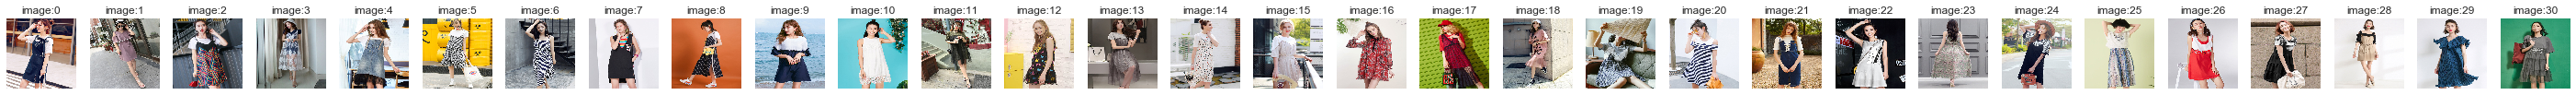

In [41]:
plot_image_sequence(img_files,user_id)

/Users/chris/anaconda/envs/virtenv/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


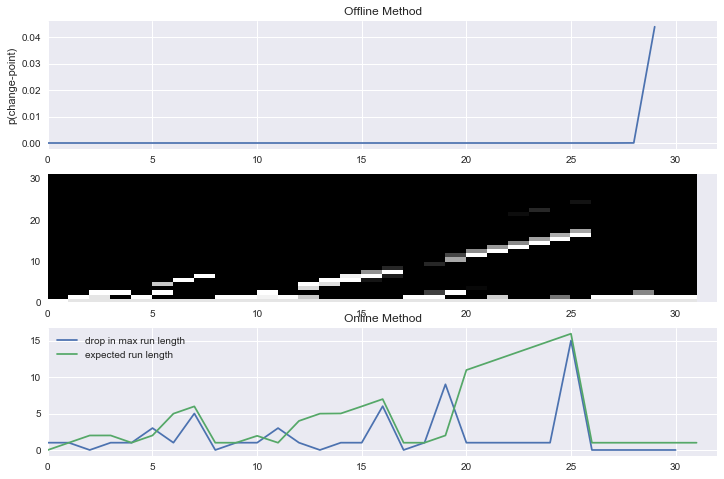

In [68]:
plot_change_points(R,Pcp)

## Plot change-points for a bunch of people.. see how often it is suggesting a change 

- how often is it suggesting a run length for of 5 etc. 


# Save

In [101]:
%%bash 
jupyter nbconvert --to html Change_Point_Detection_in_Trajectories.ipynb && mv Change_Point_Detection_in_Trajectories.html ../notebook_htmls/Change_Point_Detection_in_Trajectories_v1.html
cp Change_Point_Detection_in_Trajectories.ipynb ../notebook_versions/Change_Point_Detection_in_Trajectories_v1.ipynb

[NbConvertApp] Converting notebook Change_Point_Detection_in_Trajectories.ipynb to html
[NbConvertApp] Writing 1804943 bytes to Change_Point_Detection_in_Trajectories.html
